In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
config = tf.compat.v1.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# Any results you write to the current directory are saved as output.

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [0]:
from tqdm.autonotebook import tqdm

/home/ahmad/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [0]:
import os
#root = '/kaggle/input/aptos2019-blindness-detection/'
root = './dat/aptos2019-blindness-detection/'
train_img_path = os.path.join(root,'train_images')
train_path = os.path.join(root,'train.csv')
test_img_path = os.path.join(root,'test_images')
test_path = os.path.join(root,'test.csv')

In [0]:
import pandas as pd
train_data = pd.read_csv(train_path)
train_data.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

In [0]:
train_data.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd46c303310>]],
      dtype=object)

In [0]:
n_classes = train_data.diagnosis.nunique()

In [0]:
classes = train_data.diagnosis.unique()

In [0]:
train_data.diagnosis.value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [0]:
train_data['id_code'] = train_data['id_code'].apply(lambda x:x+'.png')
train_data['diagnosis'] = train_data['diagnosis'].apply(lambda x:str(x))
train_data.head()

id_code diagnosis
0  000c1434d8d7.png         2
1  001639a390f0.png         4
2  0024cdab0c1e.png         1
3  002c21358ce6.png         0
4  005b95c28852.png         0

In [0]:
train_data.dtypes

id_code      object
diagnosis    object
dtype: object

# Model

In [0]:
# define the size of our input data
sz=224

In [0]:

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.applications.vgg16 import VGG16

'''
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(sz, sz, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))
'''
'''
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(sz, sz, 3))
'''
conv_base = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(sz, sz, 3))

conv_base.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________

In [0]:
'''
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D)
'''
'''
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(n_classes, activation='softmax'))
'''
inp = layers.Input(shape=(sz,sz,3))
conv_base = ResNet50(include_top=False,
               weights='imagenet',
               input_tensor=inp)

x = layers.GlobalAveragePooling2D()(conv_base.output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.5)(x)
out = layers.Dense(n_classes, activation='softmax')(x)
model = models.Model(inp, out)

In [0]:
#model.summary()

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


# Warm up

In [0]:
conv_base.trainable = False

In [0]:
#model.summary()

# Train

In [0]:
from sklearn.utils import shuffle
train_data = shuffle(train_data, random_state=8)

In [0]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_data, test_size=0.15, random_state=8, stratify=train_data[['diagnosis']])

In [0]:
#import keras
#from keras.models import Sequential, Model 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.applications.vgg16 import VGG16, preprocess_input
#from keras.layers import Dropout, Flatten,Dense


import numpy as np
import os
from matplotlib import image,patches,patheffects
import matplotlib.pyplot as plt
from PIL import Image

from keras.applications.resnet50 import preprocess_input

# our batch size
bs=32

# No need for preprocess_fn as it will be handled in target_sz of the generator

import cv2
'''
def preprocess_input(img):
    #return img/255#cv2.resize(img, (sz,sz))
    return img.astype('float32')/255
'''
# preprocess_input is for VGG16 in our case
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True) 

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) 


train_batches = train_datagen.flow_from_dataframe(train_df, # The df
                                                  train_img_path, # Place on desk
                                                  x_col='id_code', # The column to get x
                                                  y_col='diagnosis', # The column to get y
                                                  #has_ext=True, 
                                                  target_size=(sz, sz), 
                                                  color_mode='rgb', 
                                                  classes=None, 
                                                  class_mode='categorical', 
                                                  batch_size=bs, 
                                                  shuffle=True)



valid_batches = valid_datagen.flow_from_dataframe(val_df, 
                                                  train_img_path, 
                                                  x_col='id_code', 
                                                  y_col='diagnosis', 
                                                  #has_ext=True, 
                                                  target_size=(sz, sz), 
                                                  color_mode='rgb', 
                                                  classes=None,#list(train_batches.class_indices),#classes, 
                                                  class_mode='categorical', 
                                                  batch_size=bs, 
                                                  shuffle=False)

NbClasses = len(train_batches.class_indices)

Using TensorFlow backend.


Found 3112 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.


In [0]:
from sklearn.metrics import cohen_kappa_score
from tensorflow.keras.callbacks import Callback
def flatten(y):
    return np.argmax(y, axis=1).reshape(-1)

class QWKEvaluation(Callback):
    def __init__(self, validation_data=(), batch_size=64, interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.batch_size = batch_size
        self.valid_generator, self.y_val = validation_data
        self.history = []

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_generator(generator=self.valid_generator,
                                                  steps=np.ceil(float(len(self.y_val)) / float(self.batch_size)),
                                                  workers=1, use_multiprocessing=True,
                                                  verbose=1)
            def flatten(y):
                return np.argmax(y, axis=1).reshape(-1)
                # return np.sum(y.astype(int), axis=1) - 1
            
            score = cohen_kappa_score(self.y_val,
                                      flatten(y_pred),
                                      labels=[0,1,2,3,4],
                                      weights='quadratic')
#             print(flatten(self.y_val)[:5])
#             print(flatten(y_pred)[:5])
            print("\n epoch: %d - QWK_score: %.6f \n" % (epoch+1, score))
            self.history.append(score)
            if score >= max(self.history):
                print('save checkpoint: ', score)
                self.model.save('Resnet50_class_w_bestqwk.h5')
val_df['diagnosis'].apply(lambda x:int(x))
qwk = QWKEvaluation(validation_data=(valid_batches, val_df['diagnosis'].apply(lambda x:int(x))),
                    batch_size=valid_batches.batch_size, interval=1)

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau,CSVLogger
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, 
                                   verbose=1, mode='min', epsilon=0.0001)
checkpoint = ModelCheckpoint('Resnet50_class_w.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=9)
#callbacks = [QWKP(), reduceLROnPlat, checkpoint, early]
callbacks = [qwk, reduceLROnPlat, checkpoint, early]

In [0]:
class_weights = [1,10,1,5,8]

# Warm up

In [0]:
from tensorflow.keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-3),
              metrics=['acc'])

In [0]:
epochs = 2



history = model.fit_generator(train_batches,
                              steps_per_epoch = train_batches.n // train_batches.batch_size,
                              epochs=epochs,
                              #validation_data=valid_batches,
                              #validation_steps = valid_batches.n // valid_batches.batch_size,
                              workers=2, 
                              use_multiprocessing=False,                              
                              callbacks=callbacks,
                              class_weight=class_weights)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
96/97 [============================>.] - ETA: 4s - loss: 1.1201 - acc: 0.6562WARNING:tensorflow:From <ipython-input-21-9854bf439c89>:20: Model.predict_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.predict, which supports generators.
18/18 [==============================] - 72s 4s/step

 epoch: 1 - QWK_score: 0.064911 

save checkpoint:  0.06491115102631018
97/97 [==============================] - 521s 5s/step - loss: 1.1149 - acc: 0.6571
Epoch 2/2
18/18 [==============================] - 90s 5s/step

 epoch: 2 - QWK_score: 0.211605 

save checkpoint:  0.21160472132334196
97/97 [==============================] - 441s 5s/step - loss: 0.7541 - acc: 0.7201


dict_keys(['loss', 'acc', 'lr'])


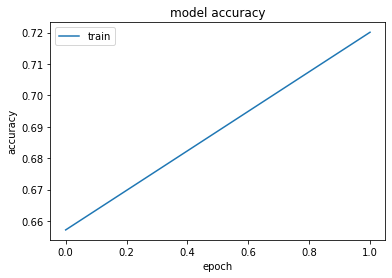

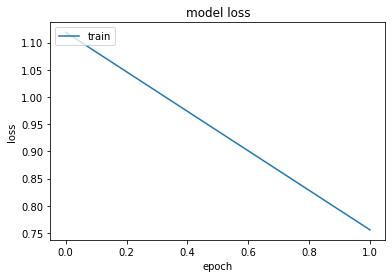

In [0]:
history = model.history
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Fine tune

In [0]:
conv_base.trainable = True
#model.summary()

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              #optimizer=AdamAccumulate(lr=1e-4, accum_iters=2),
              metrics=['acc'])

In [0]:
epochs = 10

history = model.fit_generator(train_batches,
                              steps_per_epoch = train_batches.n // train_batches.batch_size,
                              epochs=epochs,
                              validation_data=valid_batches,
                              validation_steps = valid_batches.n // valid_batches.batch_size,
                              workers=1, 
                              use_multiprocessing=False,
                              callbacks=callbacks,
                              class_weight=class_weights)

Epoch 1/10
18/18 [==============================] - 53s 3s/step

 epoch: 1 - QWK_score: 0.704091 

save checkpoint:  0.7040905855281672

Epoch 00001: val_loss improved from inf to 0.94582, saving model to Resnet50_class_w.h5
97/97 [==============================] - 551s 6s/step - loss: 0.6499 - acc: 0.7532 - val_loss: 0.9458 - val_acc: 0.7206
Epoch 2/10
18/18 [==============================] - 52s 3s/step

 epoch: 2 - QWK_score: 0.837813 

save checkpoint:  0.8378133378961605

Epoch 00002: val_loss improved from 0.94582 to 0.72444, saving model to Resnet50_class_w.h5
97/97 [==============================] - 559s 6s/step - loss: 0.5371 - acc: 0.7997 - val_loss: 0.7244 - val_acc: 0.7629
Epoch 3/10
18/18 [==============================] - 53s 3s/step

 epoch: 3 - QWK_score: 0.800513 


Epoch 00003: val_loss did not improve from 0.72444
97/97 [==============================] - 563s 6s/step - loss: 0.4802 - acc: 0.8162 - val_loss: 0.7689 - val_acc: 0.7426
Epoch 4/10
18/18 [=================

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


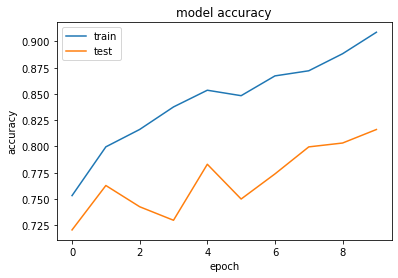

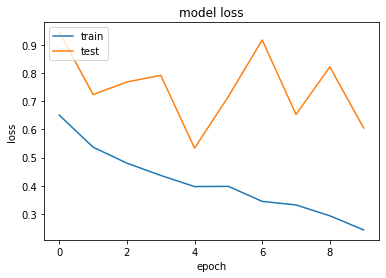

In [0]:
# list all data in history
history = model.history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Visualization

In [0]:
#model.summary()

In [0]:
from tensorflow.keras import backend as K

import cv2
def grad_CAM(model, layer, img):
    #plt.imshow(img)
    #plt.show()
    x = np.expand_dims(preprocess_input(img), 0)
    preds = model.predict(x)
    idx = np.argmax(preds[0])

    
    # This is the index entry in the prediction vector
    output = model.output[:, idx]

    # The is the output feature map of the `block5_conv3` layer,
    # the last convolutional layer in VGG16
    last_conv_layer =model.layers[layer] #model.get_layer('block5_conv3')

    # This is the gradient of the "african elephant" class with regard to
    # the output feature map of `block5_conv3`
    #grads = tf.gradients(output, last_conv_layer.output)[0]#K.gradients(output, last_conv_layer.output)[0]
    grads = tf.gradients(output, last_conv_layer.get_output_at(-1))[0]

    # This is a vector of shape (512,), where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of `block5_conv3`,
    # given a sample image
    #iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.get_output_at(-1)[0]])

    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image of two elephants
    pooled_grads_value, conv_layer_output_value = iterate([x])

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the elephant class
    for i in range(last_conv_layer.output_shape[-1]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    #plt.matshow(heatmap)
    #plt.show()    
    heatmap_raw = heatmap
    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    #eatmap = np.uint8(heatmap)

    # We apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # 0.4 here is a heatmap intensity factor
    #superimposed_img = heatmap * 0.1 + img
    opacity = 0.2
    superimposed_img = cv2.addWeighted(heatmap,opacity,img, 1-opacity, 0)
    #plt.imshow(img)
    #plt.show()
    # Save the image to disk
    #cv2.imwrite('elephant_cam.jpg', superimposed_img)
    #plt.imshow(superimposed_img)
    return superimposed_img, heatmap_raw

In [0]:
train_data = pd.read_csv(train_path)

In [0]:
conv_base_layer_idx = -9

Class:  0
Pred class:  0  Correct class:  0


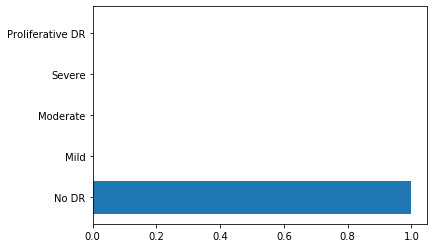

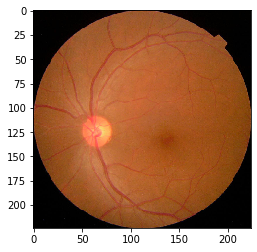

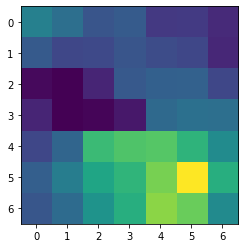

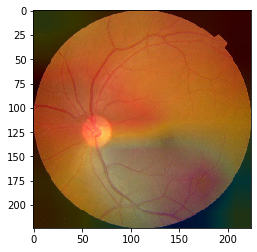

Pred class:  0  Correct class:  0


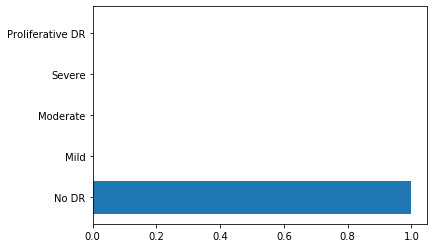

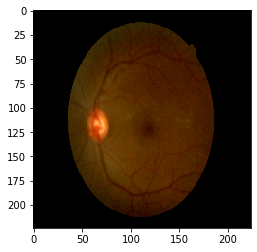

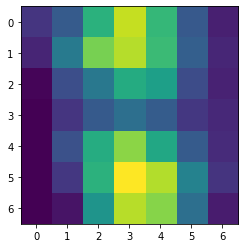

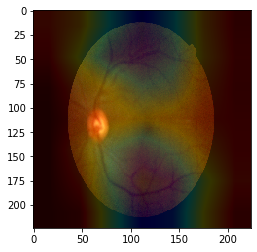

Pred class:  0  Correct class:  0


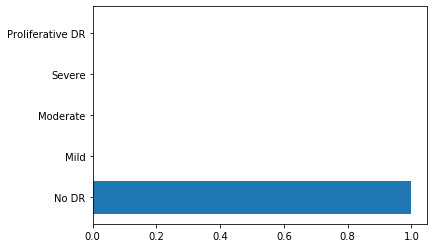

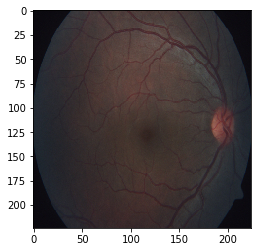

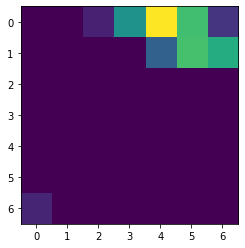

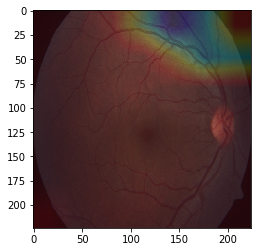

Class:  1
Pred class:  1  Correct class:  1


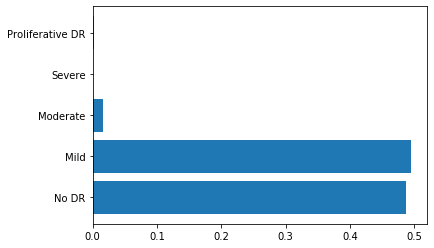

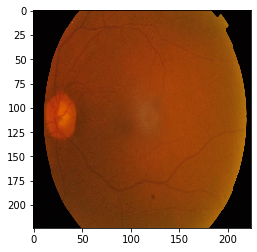

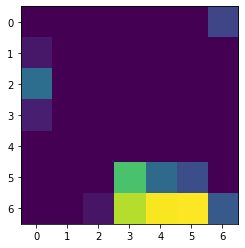

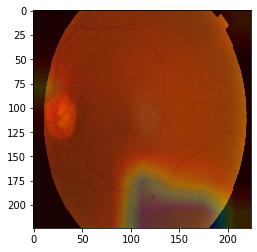

Pred class:  1  Correct class:  1


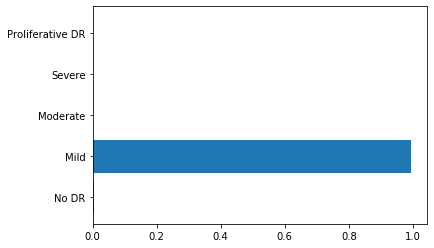

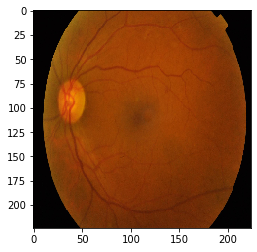

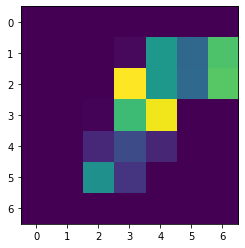

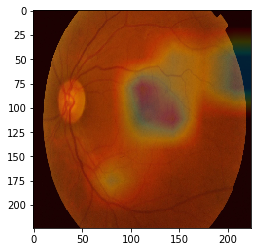

Pred class:  0  Correct class:  1


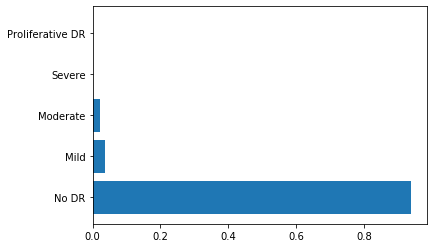

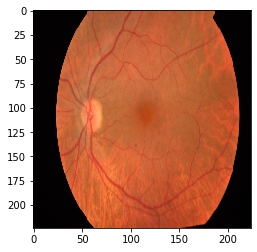

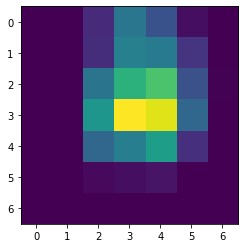

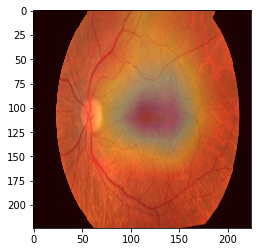

Class:  2
Pred class:  2  Correct class:  2


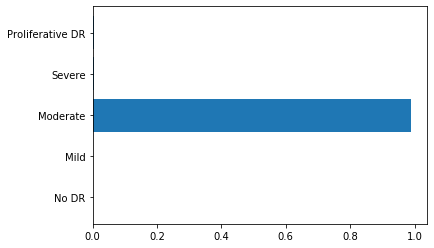

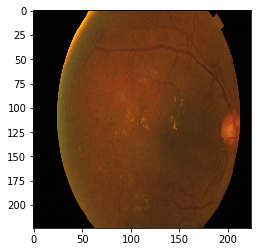

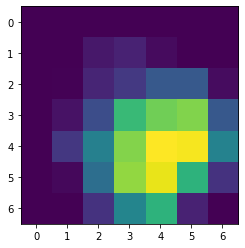

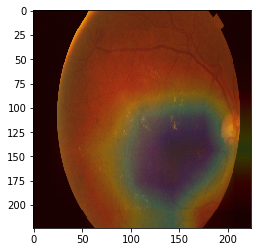

Pred class:  2  Correct class:  2


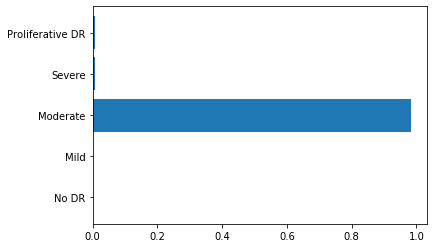

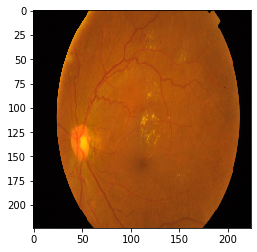

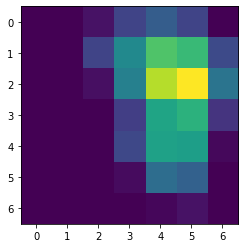

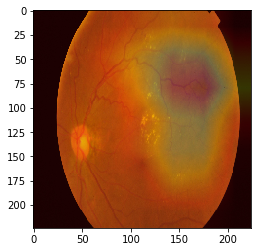

Pred class:  2  Correct class:  2


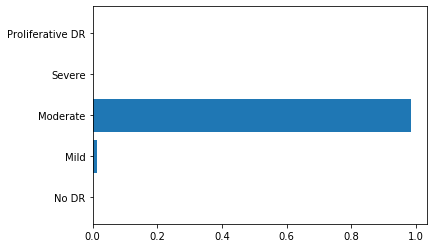

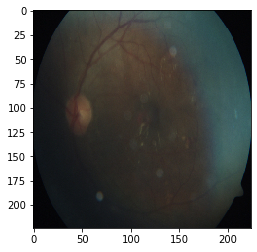

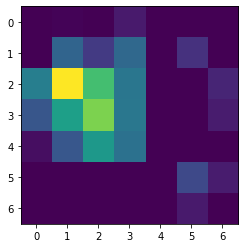

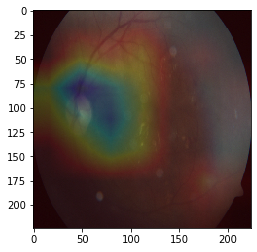

Class:  3
Pred class:  3  Correct class:  3


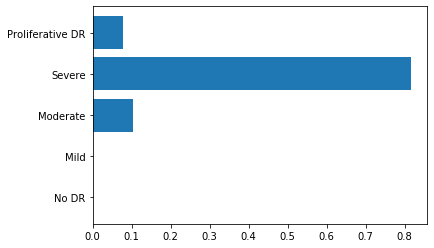

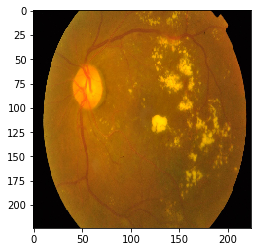

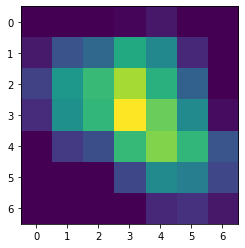

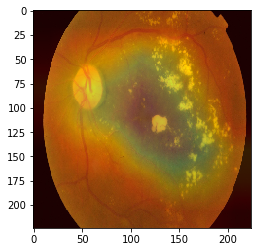

Pred class:  3  Correct class:  3


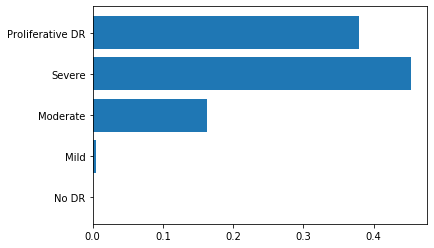

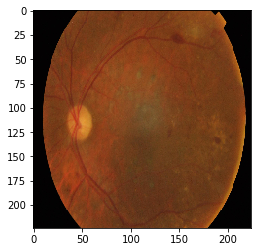

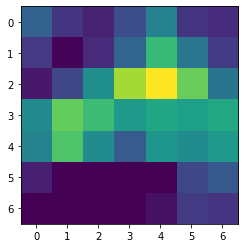

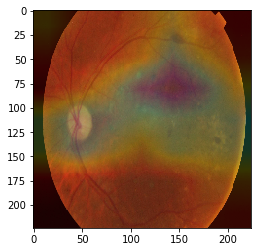

Pred class:  3  Correct class:  3


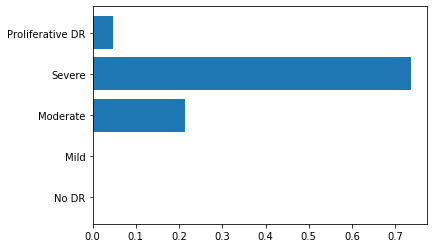

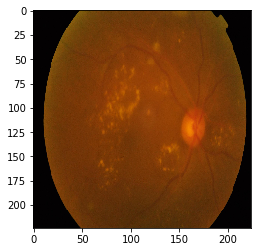

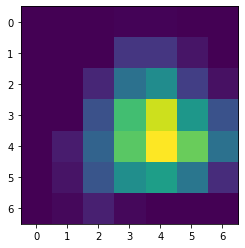

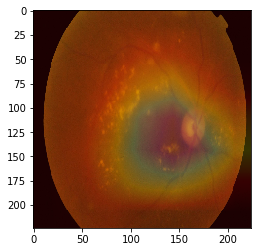

Class:  4
Pred class:  4  Correct class:  4


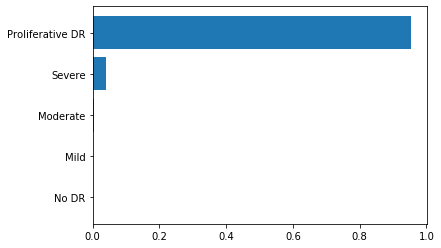

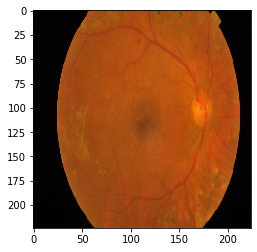

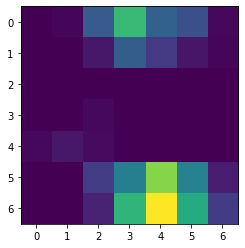

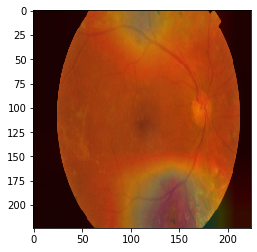

Pred class:  4  Correct class:  4


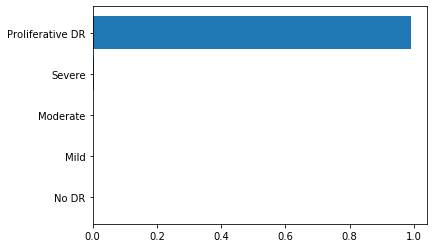

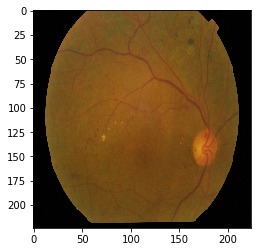

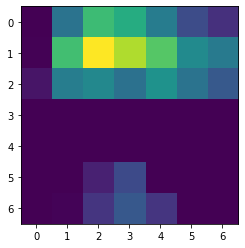

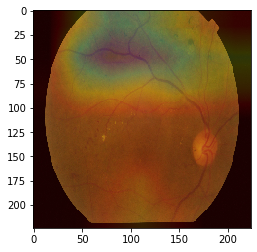

Pred class:  3  Correct class:  4


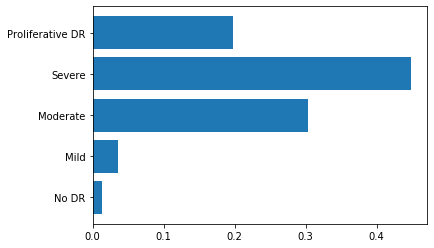

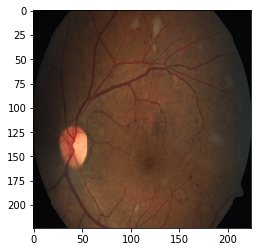

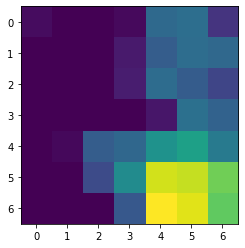

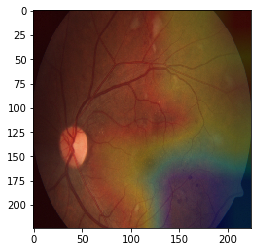

In [0]:
from keras.preprocessing import image
for cl in range(5):
    print("Class: ", str(cl))
    for i in range(3):
        
        img = image.load_img(train_img_path + '/' + train_data[train_data.diagnosis==cl].iloc[i].id_code + '.png', target_size=(sz,sz))
        
        
        #plt.imshow(img)
        #plt.show()
        # = preprocess_input(image.img_to_array(img))
        x = np.expand_dims(preprocess_input(np.array(img)), 0)

        preds = model.predict(x)
        idx = np.argmax(preds[0])
        print('Pred class: ', str(idx), ' Correct class: ', str(cl))
        plt.barh(["No DR","Mild","Moderate","Severe","Proliferative DR"], preds[0])
        plt.show()
        plt.imshow(np.array(img))
        plt.show()
        #superimposed_img, heatmap = grad_CAM(model=model, layer=conv_base_layer_idx, img_raw=image.img_to_array(img))
        superimposed_img, heatmap = grad_CAM(model=model, layer=conv_base_layer_idx, img=np.array(img))
        plt.imshow(heatmap)
        plt.show()
        plt.imshow(superimposed_img)
        plt.show()

* The 7x7 grid is too coarse.

Let's try more fine grids



In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [0]:
conv_base_layer_idx = -41
print(model.layers[conv_base_layer_idx])
print(model.layers[conv_base_layer_idx].output_shape)

(None, 14, 14, 1024)


Class:  0
Pred class:  0  Correct class:  0


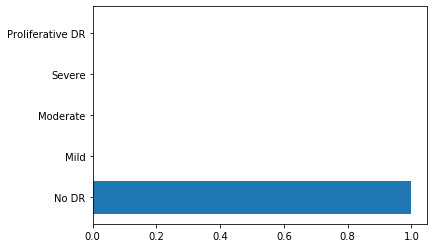

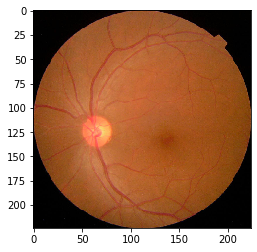

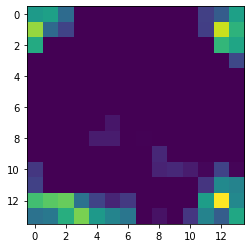

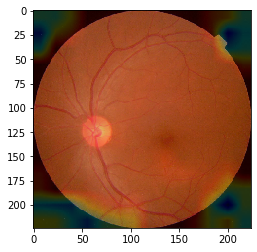

Pred class:  0  Correct class:  0


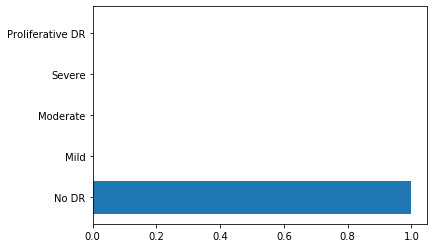

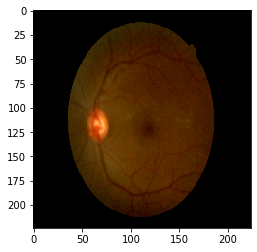

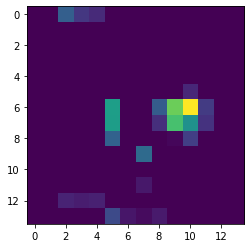

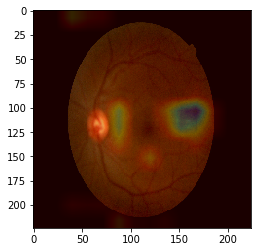

Pred class:  0  Correct class:  0


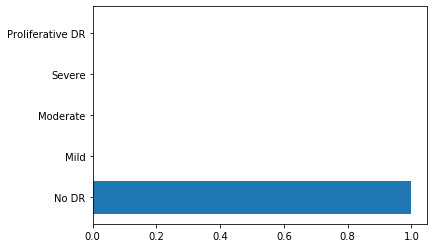

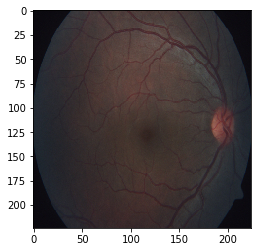

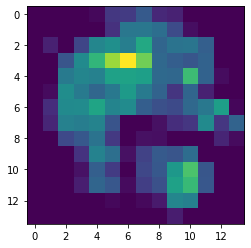

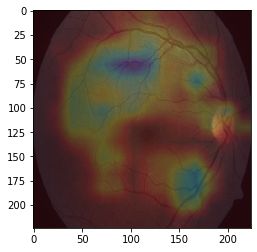

Class:  1
Pred class:  1  Correct class:  1


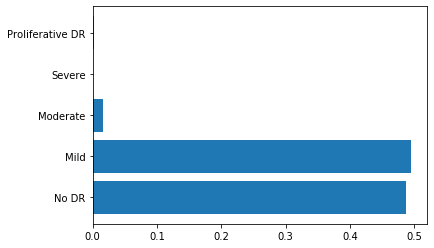

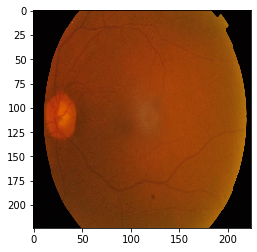

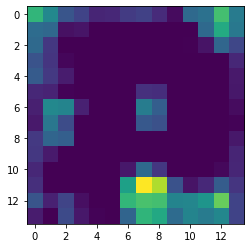

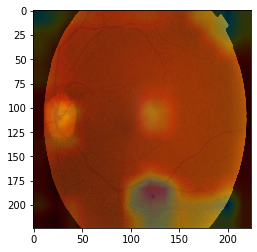

Pred class:  1  Correct class:  1


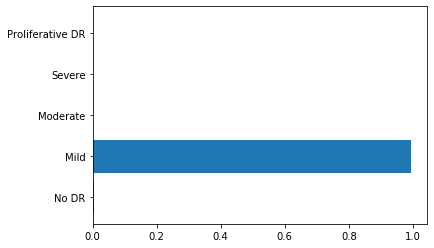

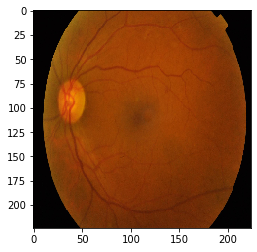

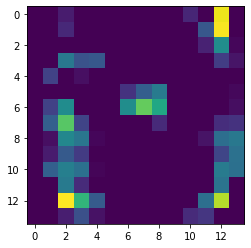

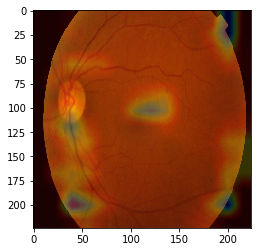

Pred class:  0  Correct class:  1


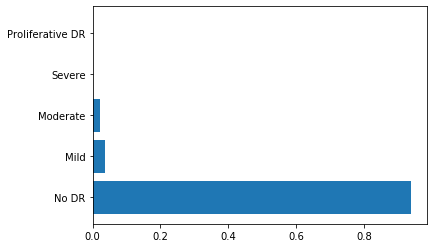

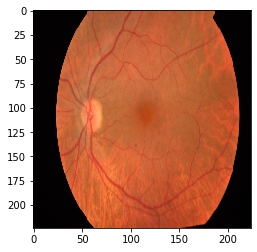

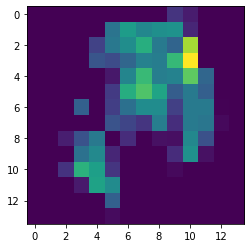

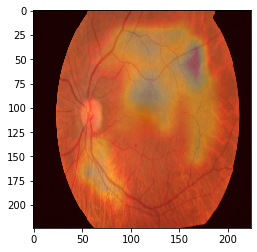

Class:  2
Pred class:  2  Correct class:  2


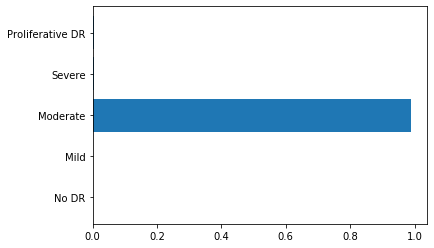

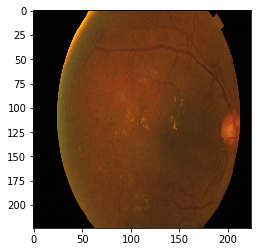

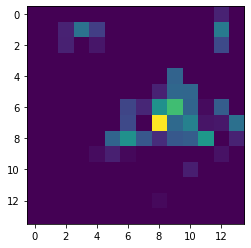

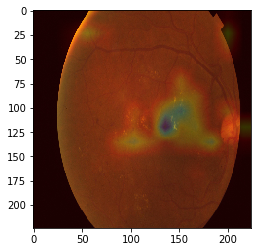

Pred class:  2  Correct class:  2


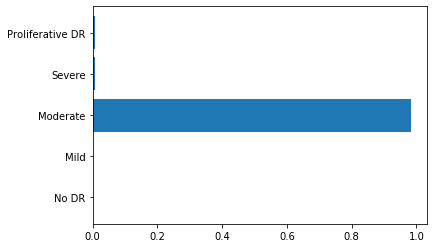

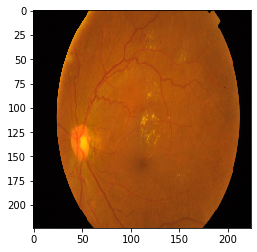

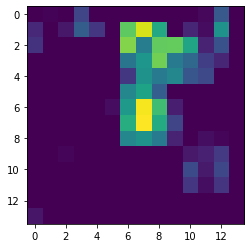

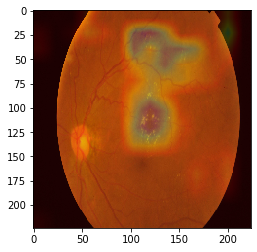

Pred class:  2  Correct class:  2


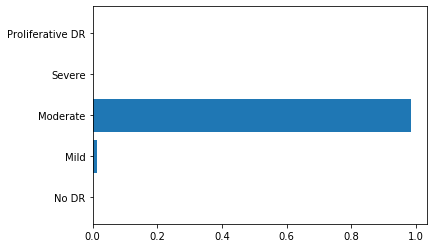

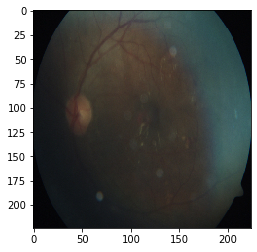

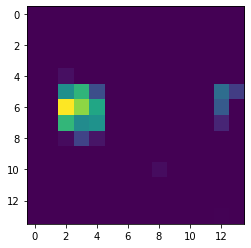

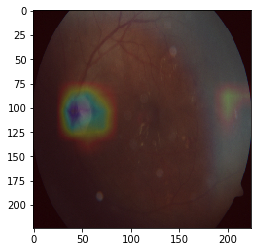

Class:  3
Pred class:  3  Correct class:  3


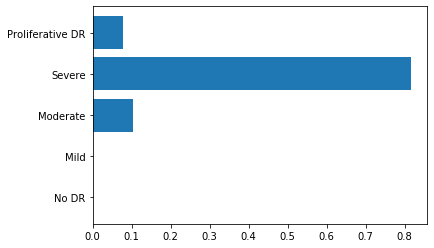

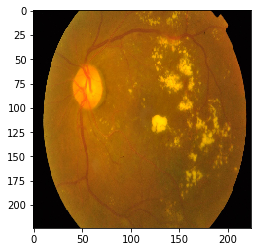

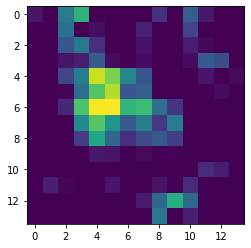

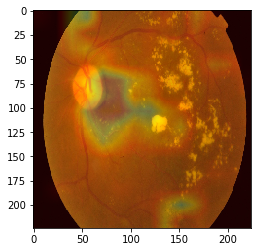

Pred class:  3  Correct class:  3


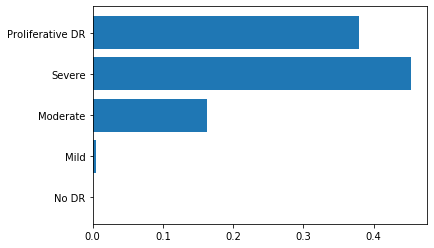

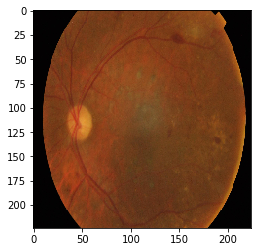

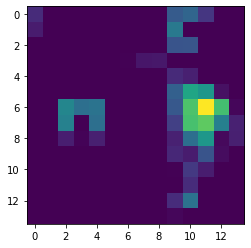

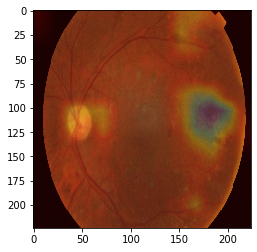

Pred class:  3  Correct class:  3


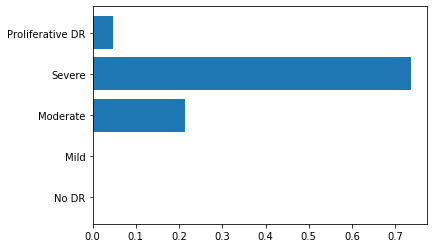

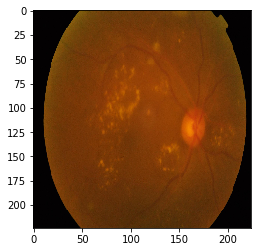

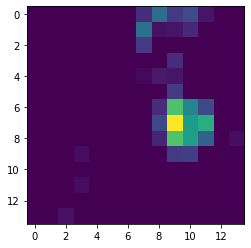

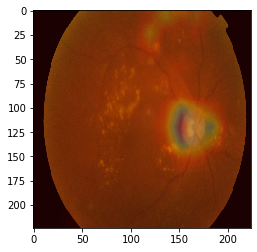

Class:  4
Pred class:  4  Correct class:  4


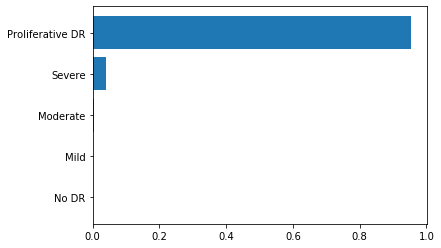

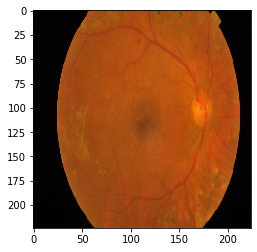

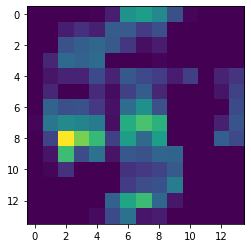

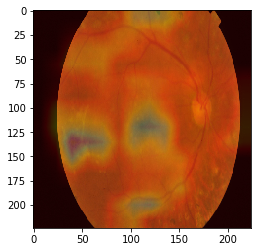

Pred class:  4  Correct class:  4


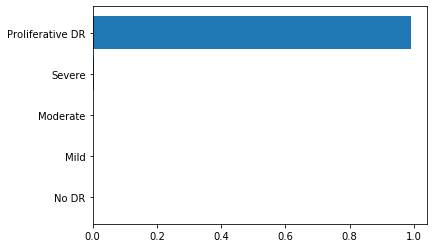

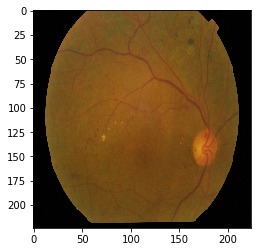

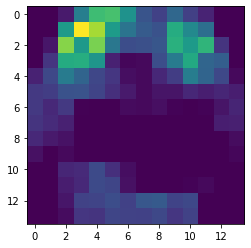

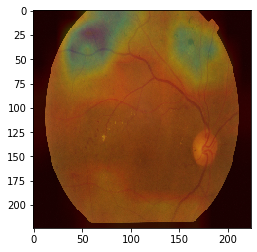

Pred class:  3  Correct class:  4


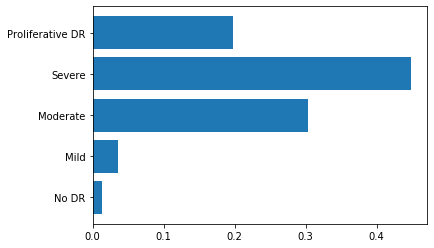

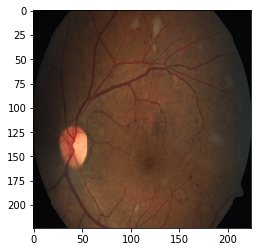

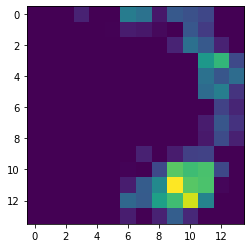

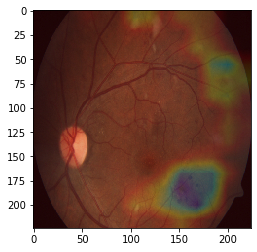

In [0]:

for cl in range(5):
    print("Class: ", str(cl))
    for i in range(3):
        
        img = image.load_img(train_img_path + '/' + train_data[train_data.diagnosis==cl].iloc[i].id_code + '.png', target_size=(sz,sz))
        
        
        #plt.imshow(img)
        #plt.show()
        # = preprocess_input(image.img_to_array(img))
        x = np.expand_dims(preprocess_input(np.array(img)), 0)

        preds = model.predict(x)
        idx = np.argmax(preds[0])
        print('Pred class: ', str(idx), ' Correct class: ', str(cl))
        plt.barh(["No DR","Mild","Moderate","Severe","Proliferative DR"], preds[0])
        plt.show()
        plt.imshow(np.array(img))
        plt.show()
        #superimposed_img, heatmap = grad_CAM(model=model, layer=conv_base_layer_idx, img_raw=image.img_to_array(img))
        superimposed_img, heatmap = grad_CAM(model=model, layer=conv_base_layer_idx, img=np.array(img))
        plt.imshow(heatmap)
        plt.show()
        plt.imshow(superimposed_img)
        plt.show()

Looks better!

In [0]:
from sklearn.metrics import confusion_matrix
#y_predict = np.asarray(model.predict(X_val))
#qwk = QWKEvaluation(validation_data=(valid_batches, val_df['diagnosis'].apply(lambda x:int(x))),batch_size=valid_batches.batch_size, interval=1)
y_val = val_df['diagnosis'].apply(lambda x:int(x))
y_predict = model.predict_generator(generator=valid_batches,
                                    steps=np.ceil(float(len(y_val)) / float(valid_batches.batch_size)),
                                    workers=1, use_multiprocessing=True,
                                    verbose=1)
            
y_predict = np.argmax(y_predict, axis=1)

y_val_ = np.array(y_val)

cm = confusion_matrix(y_val_, y_predict)

18/18 [==============================] - 52s 3s/step


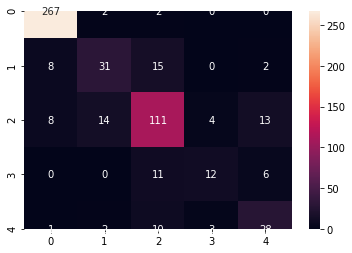

In [0]:
import seaborn as sns
sns.heatmap(cm, annot=True, fmt="d")

As expected, the best performing classes are the dominant ones.

The model is not able to recognize the rare class 3 (severe)
However, it seems to capture interesting abnormal areas in the feature map

Visually, the image looks "abnormal" in many areas.

It's usually confused the the "Moderate" class.

# Submission

In [0]:
submission = pd.read_csv(os.path.join(root, 'sample_submission.csv'))
submission.head()

id_code  diagnosis
0  0005cfc8afb6          0
1  003f0afdcd15          0
2  006efc72b638          0
3  00836aaacf06          0
4  009245722fa4          0

In [0]:
submission['id_code'] = submission['id_code'].apply(lambda x:x+'.png')
#submission['diagnosis'] = submission['diagnosis'].apply(lambda x:str(x))
submission.head()

id_code  diagnosis
0  0005cfc8afb6.png          0
1  003f0afdcd15.png          0
2  006efc72b638.png          0
3  00836aaacf06.png          0
4  009245722fa4.png          0

In [0]:
test_df = pd.read_csv(test_path)

In [0]:
test_df['id_code'] = test_df['id_code'].apply(lambda x:x+'.png')
#test_df['diagnosis'] = test_df['diagnosis'].apply(lambda x:str(x))
test_df.head()

id_code
0  0005cfc8afb6.png
1  003f0afdcd15.png
2  006efc72b638.png
3  00836aaacf06.png
4  009245722fa4.png

In [0]:
test_df.head()

id_code
0  0005cfc8afb6.png
1  003f0afdcd15.png
2  006efc72b638.png
3  00836aaacf06.png
4  009245722fa4.png

In [0]:
len(test_df)

1928

In [0]:
!ls {test_img_path}

0005cfc8afb6.png  445fec0912db.png  85ceca982305.png  c346339ff00f.png
003f0afdcd15.png  446d2a4606bf.png  85f608bcb50a.png  c370a38c855e.png
006efc72b638.png  446edc2b054f.png  862cc91ef3f0.png  c38bfcb69bac.png
00836aaacf06.png  447d8e8f446d.png  8634cfaa63c5.png  c39399ebd841.png
009245722fa4.png  448c1f328542.png  86683eb8921e.png  c39c40be80e9.png
009c019a7309.png  44c7a0b9820f.png  86c179395e2b.png  c39d7fde814c.png
010d915e229a.png  450e2a692142.png  86ca8c8d563d.png  c3e13501e198.png
0111b949947e.png  4541683880a4.png  86fd5df366b2.png  c3e311d899ed.png
01499815e469.png  456b6a5827d4.png  87252c491c19.png  c3fea3498883.png
0167076e7089.png  456c55e0d8f9.png  872d2097a7ad.png  c423a0b222de.png
01c31b10ab99.png  4578ed5eeb9f.png  87487c4c4ddc.png  c434df57e02b.png
01c5ba195207.png  458b2446e3dd.png  8750b8bfe28a.png  c43d6133ca37.png
01e4d86b3a30.png  45ca3fb3bfc5.png  8798cccbcb0d.png  c475aefa6255.png
020921b796d5.png  45f34a152021.png  880eacc5ab23.png  c47fe8e08b85.png
020f69

In [0]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
'''
submission.diagnosis = submission.diagnosis.apply(str)
test_batches = test_datagen.flow_from_dataframe(submission, 
                                                  test_img_path, 
                                                  x_col='id_code', 
                                                  y_col='diagnosis', 
                                                  #has_ext=True, 
                                                  target_size=(sz, sz), 
                                                  color_mode='rgb', 
                                                  classes=list(train_batches.class_indices),#classes, 
                                                  class_mode='categorical', #'input',
                                                  batch_size=bs, 
                                                  shuffle=False)
'''

test_batches = test_datagen.flow_from_dataframe(submission,#test_df, 
                                                  test_img_path, 
                                                  x_col='id_code', 
                                                  #y_col='diagnosis', 
                                                  #has_ext=True, 
                                                  target_size=(sz, sz), 
                                                  color_mode='rgb', 
                                                  #classes=list(train_batches.class_indices),#classes, 
                                                  class_mode=None,#'categorical', #'input',
                                                  batch_size=1, 
                                                  shuffle=False)

preds = []
'''
i = 0
for batch in test_batches:

    #print(model.predict(batch))
    preds.append(model.predict(batch))#(np.argmax(model.predict(batch)))
    i+=1
    print(i)
    if i == len(test_df):
        break
'''        

for i in tqdm(range(len(test_df))):
    batch = next(test_batches)
    preds.append(np.argmax(model.predict(batch)))

Found 1928 validated image filenames.


In [0]:
import numpy as np
submission['diagnosis'] = preds
submission.to_csv('submission.csv', index=False)
submission.head()

id_code  diagnosis
0  0005cfc8afb6.png          1
1  003f0afdcd15.png          2
2  006efc72b638.png          3
3  00836aaacf06.png          2
4  009245722fa4.png          4